In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import logistic

import pystan
import arviz

from src.plotting import fit_plot_prior

In [2]:
random.seed(42)
np.random.seed(42)

### Introduction

In this notebook we are going to do two things:

1. Simulate fake data and ensure we can recover those parameters back from Stan.
2. Perform prior-predictive checking to ensure any simulated fake data looks reasonable.

The model we are fitting is an ordered logistic regression model with 3 outcomes for chess Player 1: lose (encoded as 1), draw (encoded as 2) or win (encoded as 3).

### Set-up the data

Given the training set for the data we have prior to 2019 has 285 playes and 1,687 games we are going to simulate datasets of that size (in fact just a single dataset for now). 

In order to start us off we need to decide which players are playing each other and we do this by randomly simulating the ranks of players who play each other for each game. 

We also, for each game, randomly assign a player as playing as white i.e. the person who moves first.

In [3]:
num_players = 285
num_games = 1687
prior_fake = np.arange(num_players, 0, -1)
prior_score_fake = (prior_fake - np.mean(prior_fake)) / (
    2 * np.std(prior_fake, ddof=1)
)

ranks_fake = (
    np.array(
        [random.sample(range(num_players), k=2) for i in range(num_games)]
    )
    + 1
)
player_1_white = np.random.binomial(1, 0.5, num_games)

### Simulate fake data

When simulating fake data we could do this outside of Stan with just point values of key parameters. Another way is to use the generated quantities block in Stan and reduce the scale parameters for our prior distributions so that the prior parameters are close to fixed i.e. we don't have a distribution in the parameter value itself. 

This means it should be easier for us to learn the actual value of the parameters and hence test the model set-up for a single simulated dataset.

We do this by setting the `scale_reduction_factor` to be a small number. 

We also add a `fit_model` term to the Stan model which will switch the likelihood on or off.

Setting things up like this means we avoid have to code up the generative process twice or have two Stan models to compile and use depending on if we are simulating fake data or fitting a model to real data.

In [4]:
model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0579f0ddd402536d08a8c68b7245d86c NOW.


In [5]:
scale_reduction_factor = 0.05

Next we define the inputs to the Stan model, specifying values for the means of the prior distributions - these are the values we hope to recover.

We set `fit_model = 0` which means the values in `ypred` from our fitted model will be draws from the prior-predictive distribution (even though our priors are very tight).

In [6]:
num_test_games = 5
test_dict = {
    # Placeholder dict for test set
    "predict_on_test_set": 0,
    "num_test_games": num_test_games,
    "p1_in_train": np.ones(num_test_games, dtype=np.uint8),
    "p2_in_train": np.ones(num_test_games, dtype=np.uint8),
    "p1_test_rank": np.ones(num_test_games, dtype=np.uint8),
    "p2_test_rank": np.ones(num_test_games, dtype=np.uint8),
    "p1_test_prior_score": np.ones(num_test_games, dtype=np.uint8),
    "p2_test_prior_score": np.ones(num_test_games, dtype=np.uint8),
    "p1_test_white": np.ones(num_test_games, dtype=np.uint8),
}

In [7]:
stan_data_fake_sim = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score_fake,
    "player_1_rank": ranks_fake[:, 0],
    "player_2_rank": ranks_fake[:, 1],
    "player_1_white": player_1_white,
    "b_mu": 0.25,
    "b_scale": 0.5 * scale_reduction_factor,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5 * scale_reduction_factor,
    "c_mu": np.array([-1.75, 1.25]),
    "c_scale": 0.5 * scale_reduction_factor,
    "w_mu": 2.5,
    "w_scale": 0.25 * scale_reduction_factor,
    "fit_model": 0,
    "y": np.random.randint(
        1, 4, size=num_games, dtype=np.uint8
    ),  # placeholder when used for fake data
}
stan_data_fake_sim.update(test_dict)

Next we simulate the fake data and the outcomes of each game is stored in `params_fake_sim["ypred"]`.

In [8]:
fit_fake_sim = model.sampling(data=stan_data_fake_sim)

params_fake_sim = fit_fake_sim.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We are now going to fit a model to this fake data. 

Note that for each game, from our simulation we actually got back a full distribution and so we take the most frequent outcome for each game as the true label.

In [9]:
y_sim = np.array(
    [np.sum(params_fake_sim["ypred"] == l, 0) for l in [1, 2, 3]]
).T
y_fake = np.argmax(y_sim, 1) + 1

stan_data_fake_fit = stan_data_fake_sim.copy()
stan_data_fake_fit["fit_model"] = 1
stan_data_fake_fit["y"] = y_fake

We now fit the model:

In [10]:
fit_fake = model.sampling(data=stan_data_fake_fit)

params_fake_fit = fit_fake.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
inference_data_fake_fit = arviz.convert_to_inference_data(fit_fake)
fake_fit_df = (
    arviz.summary(inference_data_fake_fit)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

We see by looking at the below plot that we are able to recover close to the correct parameters.

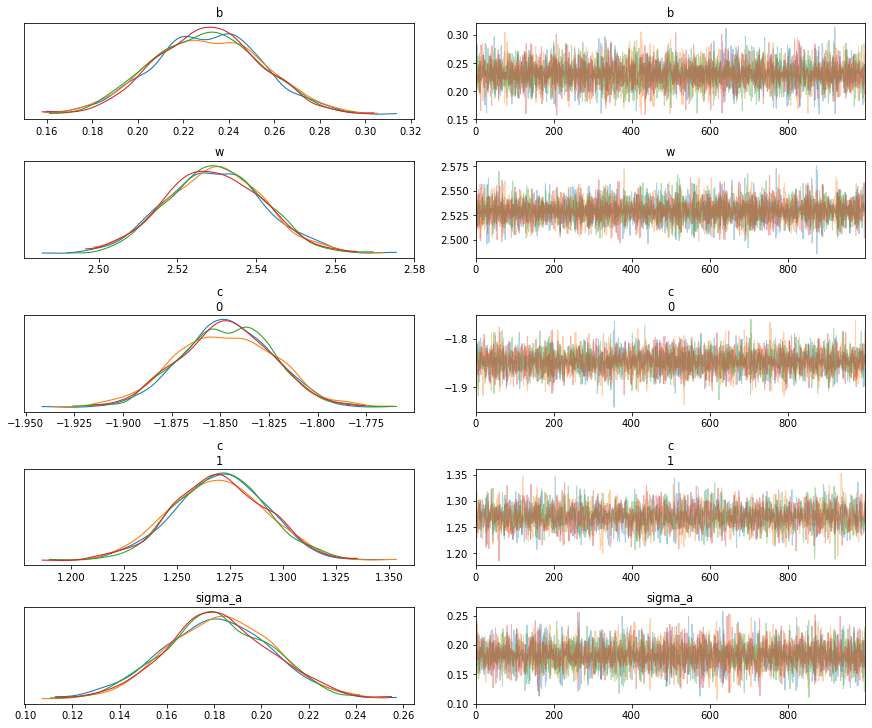

In [12]:
arviz.plot_trace(inference_data_fake_fit, var_names=["b", "w", "c", "sigma_a"]);

### Prior predictive simulation

Next we are going to simulate from the priors we have and look at the generated data to see if it looks plausible and that by changing the priors the model and simulated fake data behaves as expected.

Note we can use the same compiled Stan model.

In [13]:
stan_data_prior_pred = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score_fake,
    "player_1_rank": ranks_fake[:, 0],
    "player_2_rank": ranks_fake[:, 1],
    "player_1_white": player_1_white,
    "b_mu": 0.0,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.25, 1.25]),
    "c_scale": 0.5,
    "w_mu": 5,
    "w_scale": 0.25,
    "fit_model": 0,
    "y": np.random.randint(
        1, 4, size=num_games, dtype=np.uint8
    ),  # placeholder when used for fake data
}

stan_data_prior_pred.update(test_dict)

In [14]:
fit_prior_pred = model.sampling(data=stan_data_prior_pred)

params_prior_pred = fit_prior_pred.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We can now change key prior parameters and see how the data behaves. For example, changing the value of `w_mu` controls how much playing as white impacts the outcome of the games and changing `b_mu` is the weight of the prior ranking score. 

We do this for several key settings of the parameters: 

#### 1. Setting `b_mu = 0` and `w_mu` positive 
This means that there is no information in the prior rankings we supply and so the player who is white will tend to win most games. In this scenario we see mostly flat lines as the ranking makes no difference.

Note there is variance in the priors and so sometimes black can still win. We can validate this by reducing the values of `b_scale` and `w_scale`.

The right plot doesn't have a symmetry with the left plot because of the specified the cutpoints given by `c_mu` - we will discuss this later on.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


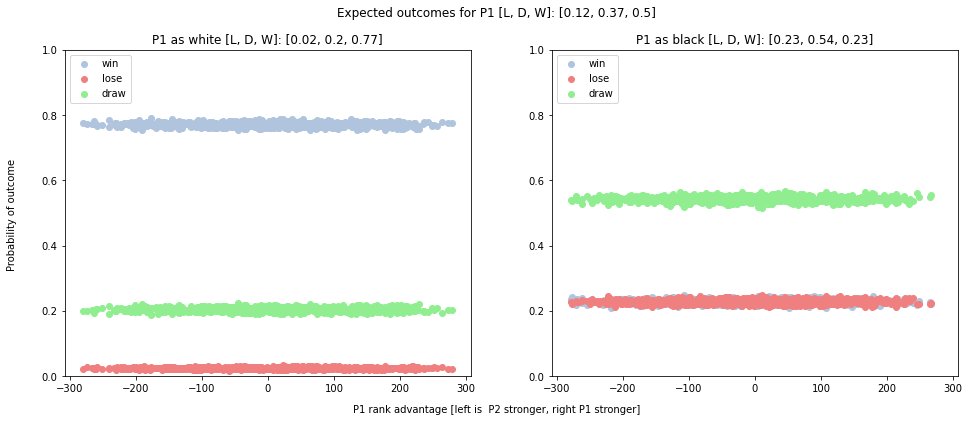

In [15]:
override_params = {
    "b_mu": 0,
    "w_mu": 2.5,
    "b_scale": 0.01,
    "w_scale": 0.01,
    "c_scale": 0.01,
    "sigma_a_scale": 0.01,
}
_ = fit_plot_prior(
    override_params, stan_data_prior_pred, model, ranks_fake, player_1_white
)

#### 2. Setting `b_mu` positive and `w_mu = 0`

In this case there is no advantage conveyed by being white and so the left and right plots are the same. In both cases the ranking of the players determines the outcome.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


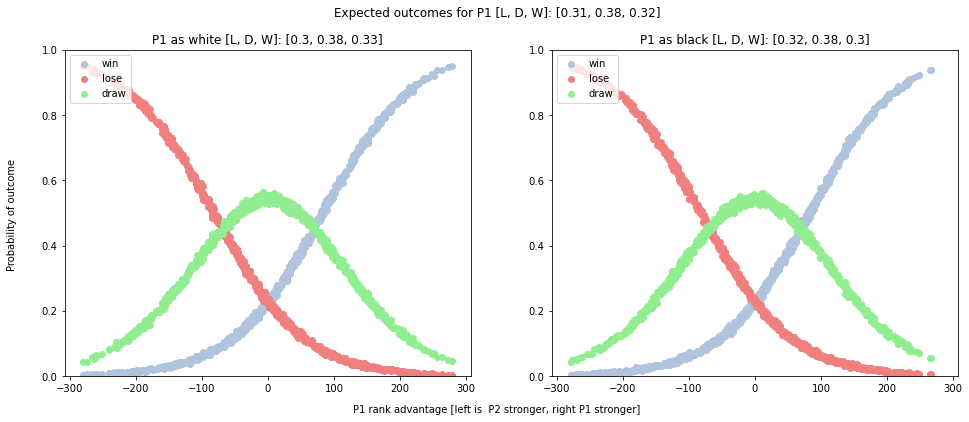

In [16]:
override_params = {
    "b_mu": 2.5,
    "w_mu": 0,
    "b_scale": 0.01,
    "w_scale": 0.01,
    "c_scale": 0.01,
    "sigma_a_scale": 0.01,
}
_ = fit_plot_prior(
    override_params, stan_data_prior_pred, model, ranks_fake, player_1_white
)

#### 3. Setting `b_mu` and `w_mu` both to be positive

This is the world we perhaps expect to be in as we know there in an advantage in chess by moving first as white and we also expect the player's rankings to have some predictive power.

On the left plot we see that P1 as white only really loses when the ranking difference becomes quite large and as the ranking disadvantage shrinks (as we move to the right along the x-axis) and turns into an advantage P1 goes from predominantly losing, to drawing and eventually winning.

On the right plot we see a symmetry between losing and winning for P1 as black whereas we'd possibly expect the plot to resemble the left hand one but with wins swapped for losses. This is again complicated by the cutpoints `c_mu` which we now turn to explain next. 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


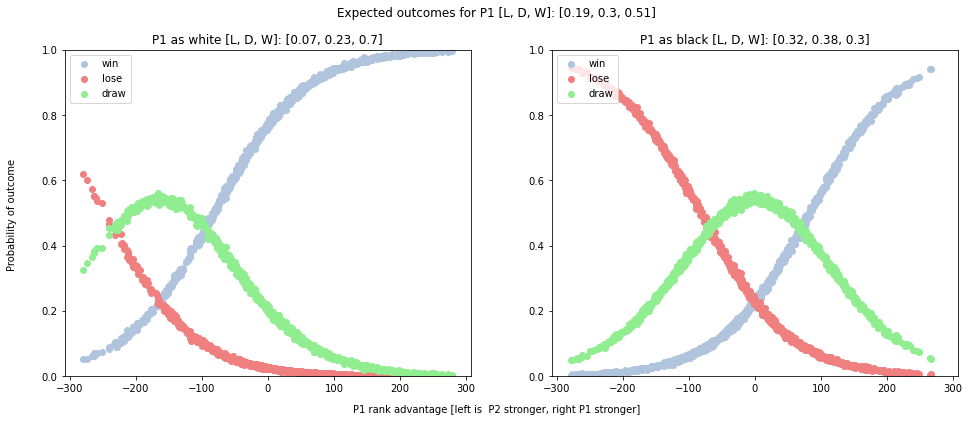

In [17]:
override_params = {
    "b_mu": 2.5,
    "w_mu": 2.5,
    "b_scale": 0.05,
    "w_scale": 0.05,
    "c_scale": 0.05,
    "sigma_a_scale": 0.05,
}
_ = fit_plot_prior(
    override_params, stan_data_prior_pred, model, ranks_fake, player_1_white
)

### What is `c_mu` and what are cutpoints?

The likelihood distribution we are using is an ordered logistic distribution. In our Stan model we have the following:


```
y[i] ~ ordered_logistic(a[player_1_rank[i]] - a[player_2_rank[i]] + w*player_1_white[i], c);

```

which means that the mean of the likelihood distribution is the difference of the abilities of the two players plus a term to model the advantage of playing as white.

What happens with the [ordered logistic distribution in Stan](https://mc-stan.org/docs/2_25/functions-reference/ordered-logistic-distribution.html) is the following:

* For a given game the abilities of the two players and the advantage of playing as white evaluates to a single number, call this number $\eta$ to match Stan. This is the mean of a [logistic distribution](https://en.wikipedia.org/wiki/Logistic_distribution).
* The values of `c_mu`, a vector of length 2 determine where to "cut" this distribution. This specifies 3 regions with 2 cutpoints. Each of these regions correspond to an outcome. These cutpoints are global i.e. the same values apply to all games.
* Based on how we set things up (by taking player 1's ability minus player 2's ability) then increasing the mean of the likelihood means increasing the probability of Player 1 winning. 
* We can use the CDF of the logistic distribution (the so called "sigmoid" transformation) to calculate the probability of falling into each region i.e. of each outcome of lose, draw and win for Player 1 (moving from left to right in the plot below).
* The values of the cutpoints will be learned by Stan when we ultimately fit a model to real data.

The upshot of all this is that when, as in the prior predictive simulation examples above, we move the mean of the likelihood (by changing `b_mu` or `w_mu` but don't change the cutpoints per `c_mu` we are only considering half of the story.

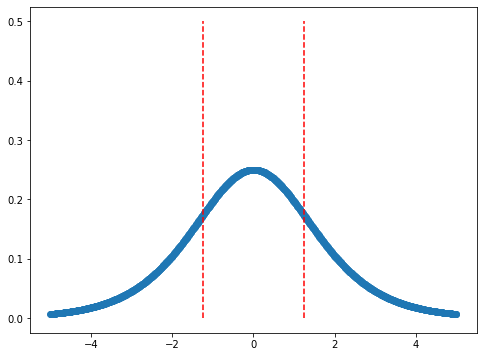

In [18]:
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, logistic().pdf(x))
ax.vlines(-1.25, 0, 0.5, color="red", linestyle="--")
ax.vlines(1.25, 0, 0.5, color="red", linestyle="--");

Let's now use the fact that we know that in the real data that around half of the games are draws and of those with outcomes roughly 2/3 are won by the player playing with the white pieces.

Note that based on `prior_score_fake` a one place difference in ranking is worth about $~0.006$.

Let's consider some cases:

* If two players are of similar rank then the likelihood is essentially centered around `w_mu` if player 1 is playing as white, and 0 if they are playing as black.
* If player 1 is ranked `r` places above player 2 then if:
    * Player 1 is playing as white the likelihood has mean of approx: 0.006 `r` * `b_mu`  + `w_mu`.
    * Player 1 is playing as black the likelihood has mean of approx: 0.006 `r` *`b_mu`.
* If player 1 is ranked `r` places below player 2 then if:
    * Player 1 is playing as white the likelihood has mean of approx: -0.006 `r` *`b_mu` + `w_mu`.
    * Player 1 is playing as black the likelihood has mean of approx: -0.006 `r` *`b_mu`.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


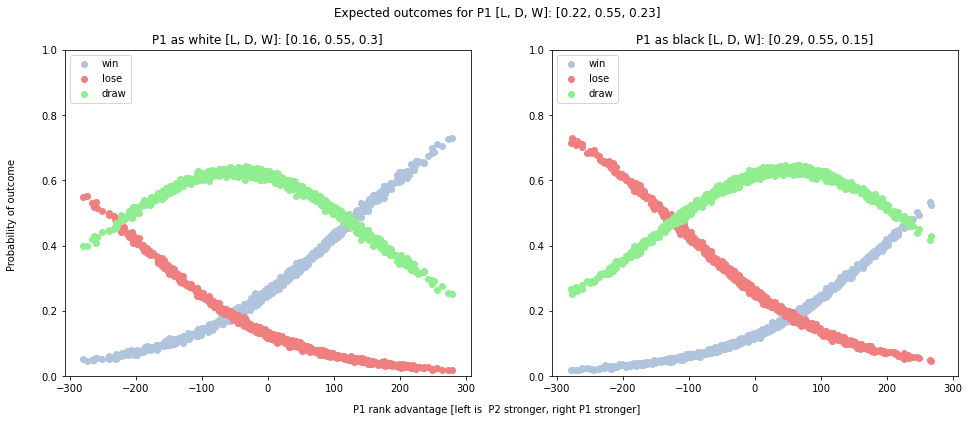

In [19]:
override_params = {"b_mu": 1.5, "w_mu": 1, "c_mu": np.array([-1.25, 2.25])}
_ = fit_plot_prior(
    override_params, stan_data_prior_pred, model, ranks_fake, player_1_white
)

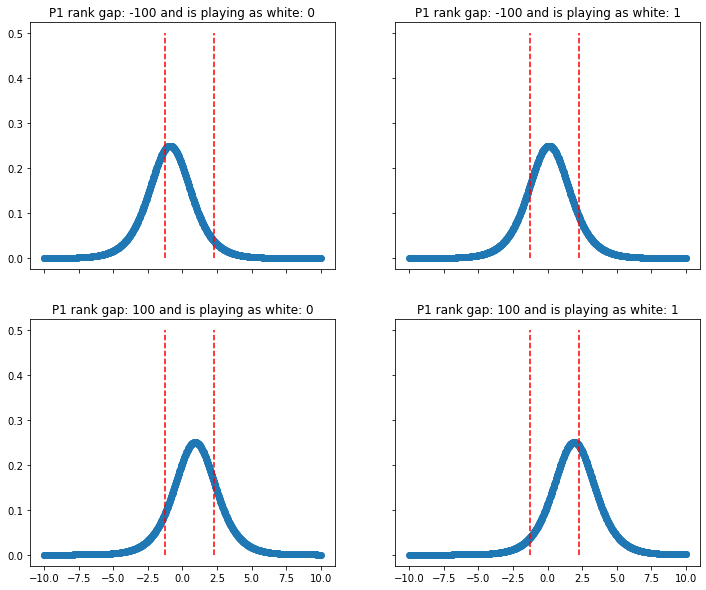

In [20]:
single_rank_value = prior_score_fake[0] - prior_score_fake[1]

x = np.linspace(-10, 10, 1000)
rank_gap = np.array([-1, 1]) * 100
p1_is_white = [0, 1]
b_mu = 1.5
w_mu = 1
cutpoints = [-1.25, 2.25]

fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.ravel()

counter = 0
for r in rank_gap:
    for w in p1_is_white:
        mu_l = single_rank_value * r * b_mu + w_mu * w
        log_dist = logistic(mu_l)

        ax[counter].scatter(x, log_dist.pdf(x))
        ax[counter].vlines(cutpoints[0], 0, 0.5, color="red", linestyle="--")
        ax[counter].vlines(cutpoints[1], 0, 0.5, color="red", linestyle="--")
        ax[counter].set_title(f"P1 rank gap: {r} and is playing as white: {w}")
        counter += 1